In [498]:
import pandas
import konlpy
import gensim
import pandas as pd

In [499]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_train.txt", filename="ratings_train.txt")
urllib.request.urlretrieve("https://raw.githubusercontent.com/e9t/nsmc/master/ratings_test.txt", filename="ratings_test.txt")

('ratings_test.txt', <http.client.HTTPMessage at 0x7b8aa377d5e0>)

In [500]:
train_data = pd.read_table('ratings_train.txt')
test_data = pd.read_table('ratings_test.txt')

In [501]:
train_data.head(3)

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0


In [502]:
train_data['label'].value_counts()

0    75173
1    74827
Name: label, dtype: int64

In [503]:
def load_data(file):
    df = pd.read_csv(file, delimiter='\t')  
    df.dropna(subset=['document', 'label'], inplace=True)  
    return df


train_data = load_data(train_txt)
test_data = load_data(test_txt)

print(f"Train: {train_data.shape}")
print(f"Test: {test_data.shape}")

Train: (149995, 3)
Test: (49997, 3)


In [504]:
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [507]:
import sentencepiece as spm
import numpy as np
from collections import Counter

temp_file_path = 'train_data.txt'
with open(temp_file_path, 'w', encoding='utf-8') as f:
    for doc in train_data['document']:
        f.write(doc + '\n') 

In [508]:
vocab_size = 16000 #4000

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=naver_review_spm_bpe --vocab_size={} --model_type=bpe'.format(temp_file_path, vocab_size)    
)

In [509]:
s = spm.SentencePieceProcessor()
s.Load('naver_review_spm_bpe.model')

True

In [510]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./naver_review_spm_uni.vocab", 'r') as f:
        vocab = f.readlines()

    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')#'post'

    return tensor, word_index, index_word

In [511]:
from tqdm import tqdm

train_lst = []
for sentence in tqdm(train_data['document']):
#     tokenized_sentence = okt.morphs(sentence, stem=True) # 토큰화
    tokenized_sentence = s.SampleEncodeAsPieces(sentence,1, 0.0)
    train_lst.append(tokenized_sentence)

100%|██████████| 149995/149995 [00:03<00:00, 37857.23it/s]


In [512]:
corpus = train_lst[0]
tensor, word_index, index_word = sp_tokenize(s, corpus)
print("words:", word_index)


words: {'<unk>': 0, '<s>': 1, '</s>': 2, '..': 3, '영화': 4, '▁영화': 5, '▁이': 6, '▁아': 7, '...': 8, '▁그': 9, '▁보': 10, '▁재': 11, 'ᄏᄏ': 12, '니다': 13, '▁정': 14, '▁나': 15, '는데': 16, '너무': 17, '▁다': 18, '▁하': 19, '▁좋': 20, '▁없': 21, '▁어': 22, '▁너무': 23, '▁사': 24, '▁내': 25, '▁감': 26, '▁진': 27, '▁재미': 28, '▁연': 29, '▁있': 30, '▁지': 31, '!!': 32, '으로': 33, '지만': 34, '하고': 35, '▁최': 36, '▁시': 37, '▁한': 38, '네요': 39, '▁안': 40, '▁1': 41, '▁정말': 42, '▁스': 43, '▁만': 44, '▁가': 45, '....': 46, '에서': 47, '▁재밌': 48, '▁기': 49, '▁봤': 50, '▁평': 51, '▁대': 52, '▁전': 53, '▁진짜': 54, '▁연기': 55, '▁마': 56, '하는': 57, '▁무': 58, '▁모': 59, '▁수': 60, '▁여': 61, '▁생': 62, '▁잘': 63, '어요': 64, '▁주': 65, '▁최고': 66, '▁않': 67, '▁더': 68, '▁평점': 69, '드라': 70, '토리': 71, '▁오': 72, '습니다': 73, '이다': 74, '▁제': 75, '▁개': 76, '▁이런': 77, '하다': 78, '▁인': 79, '▁말': 80, '▁배': 81, '드라마': 82, '▁생각': 83, '▁ᄏᄏ': 84, '▁왜': 85, '▁자': 86, '들이': 87, '▁같': 88, '▁못': 89, '▁스토리': 90, '▁소': 91, '▁남': 92, '▁알': 93, '▁본': 94, '까지': 95, '▁느': 96, '▁유': 9

In [513]:
def load_data_with_spm(train_data, test_data, num_words=10000):
    train_data.drop_duplicates(subset=['document'], inplace=True)
    train_data = train_data.dropna(how = 'any') 
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    X_train = []
    for sentence in train_data['document']:
        temp_X = s.EncodeAsIds(sentence) 
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = s.EncodeAsIds(sentence) 
        X_test.append(temp_X)
    
    # 상위 10000개의 단어만 선택하고, 인덱스 생성
    words = np.concatenate(X_train).tolist()
    counter = Counter(words)
    counter = counter.most_common(num_words-4)  # 4는 [PAD], [UNK], [START], [END] 등을 위해 예비
    vocab = ['', '', '', ''] + [key for key, _ in counter]
    word_to_index = {word:index for index, word in enumerate(vocab)}
        
    def wordlist_to_indexlist(wordlist):
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
        
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

X_train, y_train, X_test, y_test, word_to_index = load_data_with_spm(train_data, test_data)


max_length: 114
min_length: 1
avg_length: 15.138478061594451


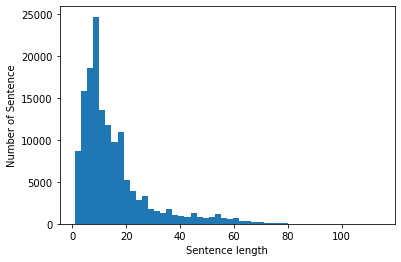

In [514]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.sequence import pad_sequences

sentence_lengths = [len(sentence) for sentence in X_train]

max_length = max(sentence_lengths)
min_length = min(sentence_lengths)
avg_length = np.mean(sentence_lengths)
median_length = np.median(sentence_lengths)

print(f"max_length: {max_length}")
print(f"min_length: {min_length}")
print(f"avg_length: {avg_length}")

plt.hist(sentence_lengths, bins=50)
plt.xlabel("Sentence length")
plt.ylabel("Number of Sentence")
plt.show()

In [515]:
len(X_train)

146182

In [516]:
word_vector_dim = 128

In [517]:
vocab_size

16000

In [518]:
max_len = int(np.percentile(sentence_lengths, 95)) 


In [519]:
max_len


45

In [520]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_X_train = pad_sequences(X_train, padding='post', maxlen=max_len)
padded_X_test = pad_sequences(X_test, padding='post', maxlen=max_len)

In [521]:
padded_X_train


array([[  54, 1149,    5, ...,    0,    0,    0],
       [1599,    6, 5025, ...,    0,    0,    0],
       [  12,  474,    3, ...,    0,    0,    0],
       ...,
       [ 105,  146,  102, ...,    0,    0,    0],
       [2191,  343, 5202, ...,    0,    0,    0],
       [ 248,    7,    3, ...,    0,    0,    0]], dtype=int32)

In [522]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [523]:
X_train, X_val, y_train, y_val = train_test_split(padded_X_train, y_train, test_size=0.2, random_state=42)

In [524]:
decoded_X_train = get_decoded_sentences(padded_X_train, index_to_word)
decoded_X_train[0]

'으며 영화 나 스파이더맨 10 다룬 <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK> <UNK>'

In [525]:
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout
import keras

bidirectional_lstm = keras.Sequential([
    Embedding(vocab_size, word_vector_dim, input_length=max_len),
    
    Bidirectional(LSTM(256, return_sequences=True)),  
    Dropout(0.5), 

    Bidirectional(LSTM(256)), 
    Dropout(0.5), 

    Dense(128, activation='relu'),
    Dropout(0.5), 

    Dense(1, activation='sigmoid')  
])

bidirectional_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bidirectional_lstm.summary()

Model: "sequential_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_24 (Embedding)     (None, 45, 128)           2048000   
_________________________________________________________________
bidirectional_28 (Bidirectio (None, 45, 512)           788480    
_________________________________________________________________
dropout_45 (Dropout)         (None, 45, 512)           0         
_________________________________________________________________
bidirectional_29 (Bidirectio (None, 512)               1574912   
_________________________________________________________________
dropout_46 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_34 (Dense)             (None, 128)               65664     
_________________________________________________________________
dropout_47 (Dropout)         (None, 128)             

In [526]:
print(f"X_train: {len(X_train)}, y_train: {len(y_train)}")
print(f"X_test: {len(X_test)}, y_test: {len(y_test)}")

X_train: 116945, y_train: 116945
X_test: 49157, y_test: 49157


In [527]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', 
                               patience=3,          
                               restore_best_weights=True)  

history = bidirectional_lstm.fit(X_train, y_train,
                                  epochs=10, 
                                  batch_size=32, 
                                  validation_data=(X_val, y_val),
                                  callbacks=[early_stopping]) 


Epoch 1/10
3655/3655 [==============================] - 70s 18ms/step - loss: 0.4095 - accuracy: 0.8127 - val_loss: 0.3477 - val_accuracy: 0.8435
Epoch 2/10
3655/3655 [==============================] - 64s 18ms/step - loss: 0.3101 - accuracy: 0.8669 - val_loss: 0.3427 - val_accuracy: 0.8500
Epoch 3/10
3655/3655 [==============================] - 64s 18ms/step - loss: 0.2616 - accuracy: 0.8903 - val_loss: 0.3634 - val_accuracy: 0.8465
Epoch 4/10
3655/3655 [==============================] - 64s 18ms/step - loss: 0.2145 - accuracy: 0.9116 - val_loss: 0.3932 - val_accuracy: 0.8402
Epoch 5/10
3655/3655 [==============================] - 64s 18ms/step - loss: 0.1689 - accuracy: 0.9323 - val_loss: 0.4941 - val_accuracy: 0.8414


### [결과]
---
[ Test1 ]    

Vocab size: 16,000 / Val Accuracy: 0.8468 / Model type: unigram / Padding : post-padding   
Vocab size: 16,000 / Val Accuracy: 0.8500 / Model type: bpe / Padding : post-padding       
Vocab size: 4,000 / Val Accuracy: 0.8584 / Model type: unigram / Padding : post-padding     
Vocab size: 4,000 / Val Accuracy: 0.8589 / Model type: bpe / Padding : post-padding     

---
- 실험 결과의 표본 수가 적어 신뢰도는 낮지만, 해당 데이터셋에서 Vocab size가 4000일 때도 불필요한 단어가 저장되는 현상을 확인했다. 이러한 불필요한 어휘 저장이 성능 저하 영향을 미쳤다고 판단된다. 
- 또한 미미하긴 하지만 BPE 방식이 Unigram 방식보다 더 나은 결과를 보인 것은, BPE(빈도기반 병합)이 Unigram(확률기반) 보다 더 나은 성능을 이끌어낼 수 있다고 해석된다.
